In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q "/content/gdrive/My Drive/aclImdb.zip"

In [0]:
import os
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 8000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [0]:
!unzip -q "/content/gdrive/My Drive/glove.6B.zip"

In [9]:
glove_dir = '/content/gdrive/My Drive/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
         embedding_matrix[i] = embedding_vector

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


**Training model without using pretrained embeddings**

In [14]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 76us/step - loss: 1.0965e-07 - acc: 1.0000 - val_loss: 0.9305 - val_acc: 0.8305
Epoch 2/10
8000/8000 [==============================] - 0s 51us/step - loss: 1.0966e-07 - acc: 1.0000 - val_loss: 0.9303 - val_acc: 0.8298
Epoch 3/10
8000/8000 [==============================] - 0s 51us/step - loss: 1.0963e-07 - acc: 1.0000 - val_loss: 0.9309 - val_acc: 0.8307
Epoch 4/10
8000/8000 [==============================] - 0s 46us/step - loss: 1.0965e-07 - acc: 1.0000 - val_loss: 0.9312 - val_acc: 0.8305
Epoch 5/10
8000/8000 [==============================] - 0s 44us/step - loss: 1.0962e-07 - acc: 1.0000 - val_loss: 0.9320 - val_acc: 0.8301
Epoch 6/10
8000/8000 [==============================] - 0s 49us/step - loss: 1.0964e-07 - acc: 1.0000 - val_loss: 0.9318 - val_acc: 0.8300
Epoch 7/10
8000/8000 [==============================] - 0s 46us/step - loss: 1.0963e-07 - acc: 1.0000 - val_loss: 0.9

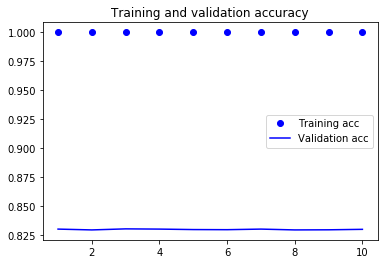

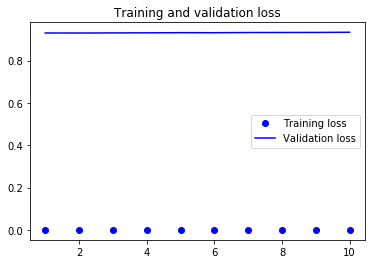

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Training model using pretrained word embeddings**

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 80us/step - loss: 0.1848 - acc: 0.9460 - val_loss: 1.2929 - val_acc: 0.6704
Epoch 2/10
8000/8000 [==============================] - 0s 50us/step - loss: 0.1790 - acc: 0.9436 - val_loss: 1.2958 - val_acc: 0.6728
Epoch 3/10
8000/8000 [==============================] - 0s 50us/step - loss: 0.1752 - acc: 0.9457 - val_loss: 1.2752 - val_acc: 0.6715
Epoch 4/10
8000/8000 [==============================] - 0s 38us/step - loss: 0.1710 - acc: 0.9480 - val_loss: 1.1804 - val_acc: 0.6707
Epoch 5/10
8000/8000 [==============================] - 0s 41us/step - loss: 0.1717 - acc: 0.9489 - val_loss: 1.3768 - val_acc: 0.6755
Epoch 6/10
8000/8000 [==============================] - 0s 42us/step - loss: 0.1721 - acc: 0.9476 - val_loss: 1.5451 - val_acc: 0.6732
Epoch 7/10
8000/8000 [==============================] - 0s 39us/step - loss: 0.1769 - acc: 0.9464 - val_loss: 1.2589 - val_acc: 0.6679
Epoch 

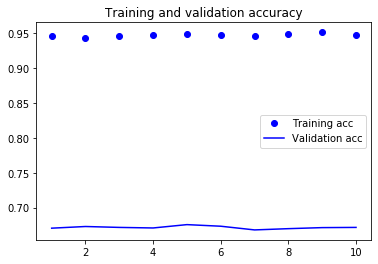

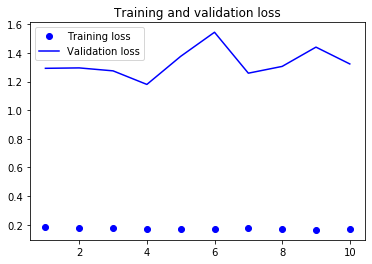

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()